100%|██████████| 1200/1200 [00:13<00:00, 86.86it/s]


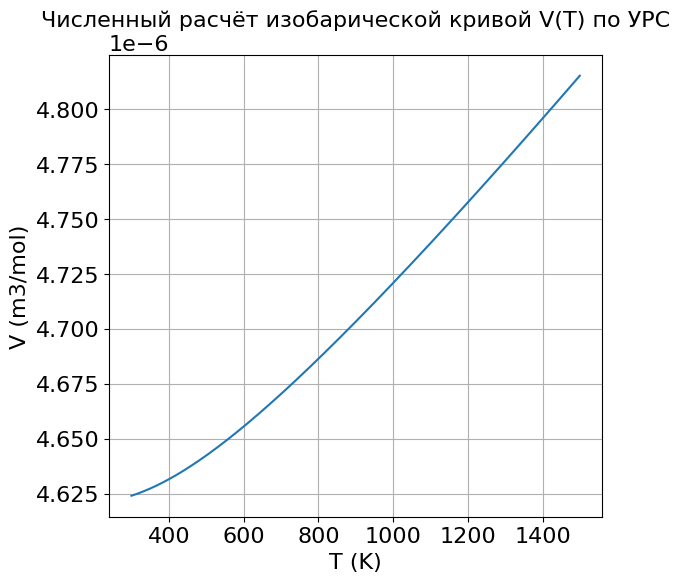

In [2]:
import numpy as np
import math 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integrate
import matplotlib

matplotlib.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
})
teta = 1250 
R = 8.31
gamma = 1.67
K = 210 * 10**9
K_ = 2.23
molar_mass_B = 10.811e-3  # kg/mol
density_B = 2340  # kg/m³
V0 = molar_mass_B / density_B  # 4.62e-6 m³/mol

T_values = []
z_values = []
v_values = []

def calc_CvEinst(T):
    exp_term = math.exp(teta/T)
    return 3 * R * (teta/T)**2 * exp_term / (exp_term - 1)**2

def isoBarical(Z, T):
    eta = (Z)**(1/3)
    term1_exp_arg = 3/2 * (K_ - 1) * (1 - eta)
    exp_val = np.exp(term1_exp_arg)
    term1 = 3 * K * (1-eta)/(eta**2) * exp_val
    term2 = integrate.quad(calc_CvEinst, 5, T)[0] * gamma / (Z * V0)
    return term1 + term2

def calculate_isobar(pressure):
    global T_values, z_values, v_values
    T_values = []
    z_values = []
    v_values = []

    for T in tqdm(range(300, 1500)):
        T_values.append(T)
        low_z, high_z = 0.6, 5
        
        for _ in range(100):
            mid_z = (low_z + high_z) / 2
            val_mid = isoBarical(mid_z, T)
            if val_mid > pressure:
                low_z = mid_z
            else: 
                high_z = mid_z
                
        z_values.append((low_z + high_z)/2)
    
    v_values = [z * V0 for z in z_values]
    
    plt.figure(figsize=(14, 6))
    #plt.subplot(1, 2, 1)
    #plt.plot(T_values, z_values)
    #plt.title("Численный расчёт изобарической кривой Z(T) по УРС")
    #plt.xlabel("T (K)")
    #plt.ylabel("Z (V/V0)")
    #plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(T_values, v_values)
    plt.title("Численный расчёт изобарической кривой V(T) по УРС")
    plt.xlabel("T (K)")
    plt.ylabel("V (m3/mol)")
    plt.grid(True)
    plt.show()

calculate_isobar(101325)

Коэффициенты: b0=4.623e-06, b1=7.998e-11, b2=1.128e-13, b3=-3.838e-17
R²: 1.000


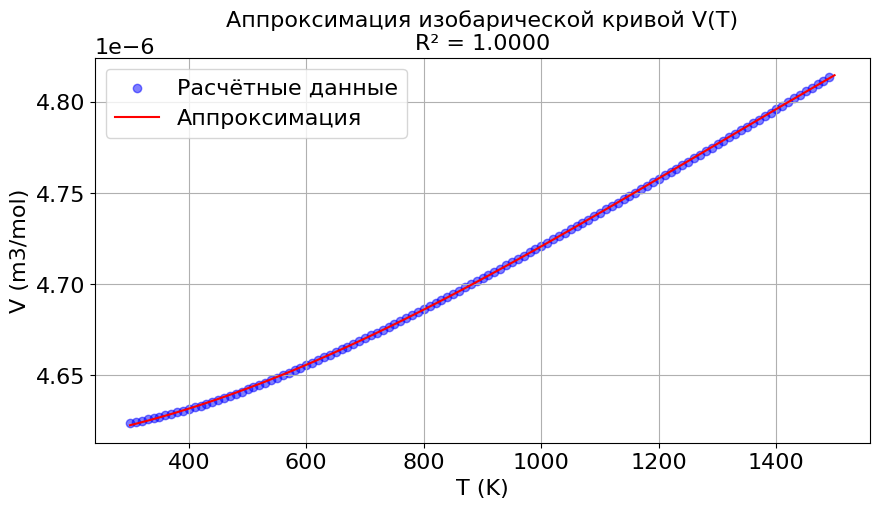

In [3]:
class CorrectedRegression:
    def __init__(self):
        self.coeffs = np.zeros(4)
        
    def fit(self, T, Z):
        T = np.asarray(T)
        V = np.array(v_values)
        Z = np.asarray(Z)
        X = T - 300  #центрирование
        
        X_mat = np.column_stack([X**0, X, X**2, X**3])
        self.coeffs = np.linalg.lstsq(X_mat, V, rcond=None)[0]
        
    def predict(self, T):
        X = np.asarray(T) - 300
        return self.coeffs[0] + self.coeffs[1]*X + self.coeffs[2]*X**2 + self.coeffs[3]*X**3
    
    def r_squared(self, T, V):
        Z_pred = self.predict(T)
        Z_mean = np.mean(V)
        ss_total = np.sum((V - Z_mean) ** 2)
        ss_res = np.sum((V - Z_pred) ** 2)
        return 1 - (ss_res / ss_total)
    
reg = CorrectedRegression()
reg.fit(T_values, v_values)
b0, b1, b2, b3 = reg.coeffs
r2 = reg.r_squared(T_values, v_values)
print(f"Коэффициенты: b0={b0:.3e}, b1={b1:.3e}, b2={b2:.3e}, b3={b3:.3e}")
print(f"R²: {reg.r_squared(T_values, v_values):.3f}")

plt.figure(figsize=(10, 5))
plt.scatter(T_values[::10], v_values[::10], label="Расчётные данные", color="blue", alpha=0.5)
plt.plot(T_values, reg.predict(T_values), label='Аппроксимация', color="red")
plt.title(f"Аппроксимация изобарической кривой V(T)\nR² = {r2:.4f}")
plt.xlabel("T (K)")
plt.ylabel("V (m3/mol)")
plt.legend()
plt.grid(True)
plt.show()

α(273K) = 5.324e-06 K^-1
α(658K) = 1.043e-05 K^-1


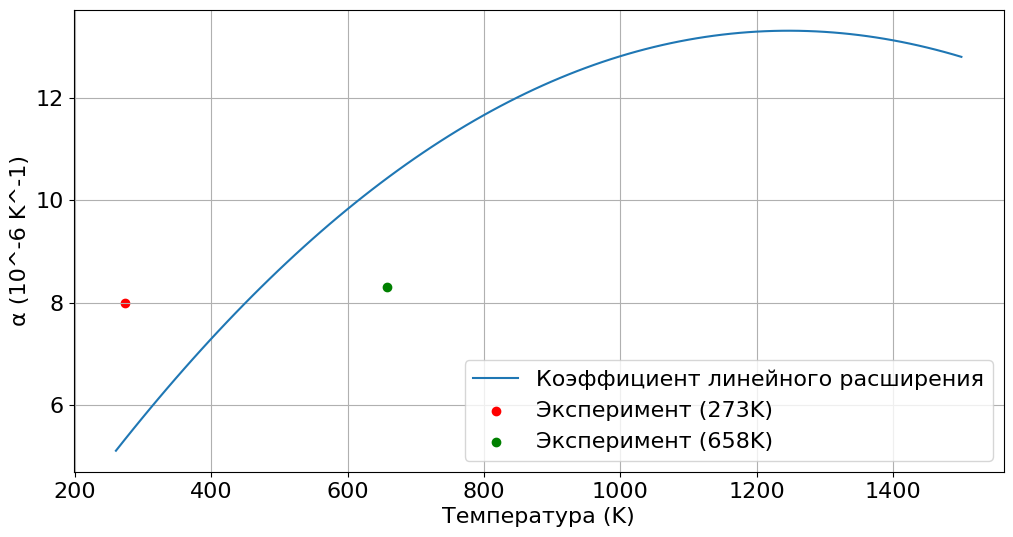

In [4]:
b0=4.623e-06
b1=7.998e-11
b2=1.128e-13
b3=-3.838e-17

def alpha_linear(T):
    X = T - 300
    V = b0 + b1*X + b2*X**2 + b3*X**3
    #V = c0 + c1*T + c2*T**2 + c3*T**3
    #dVdT = c1 + 2*c2*T + 3*c3*T**2
    dVdT = b1 + 2*b2*X + 3*b3*X**2 
    return (dVdT/V)/3

T_test = [273, 658]
for T in T_test:
    print(f"α({T}K) = {alpha_linear(T):.3e} K^-1")


T_range = np.linspace(260, 1500, 100)
alpha = [alpha_linear(T)*1e6 for T in T_range]  #10^-6 K^-1

plt.figure(figsize=(12, 6))
plt.plot(T_range, alpha, label='Коэффициент линейного расширения')
plt.xlabel("Температура (K)"); plt.ylabel("α (10^-6 K^-1)")
plt.scatter(273, 8, color='r', label='Эксперимент (273K)')
plt.scatter(658, 8.3, color='g', label='Эксперимент (658K)')
plt.legend()
plt.grid(True)
plt.show()

#Расчёт Cantera (учесть центрирование!)

C:\Temp\ipykernel_6088\3329804155.py:62: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  plt.plot([273, 658], [8, 8.3], 'ko', label='Экспериментальные данные [25]', color="green")


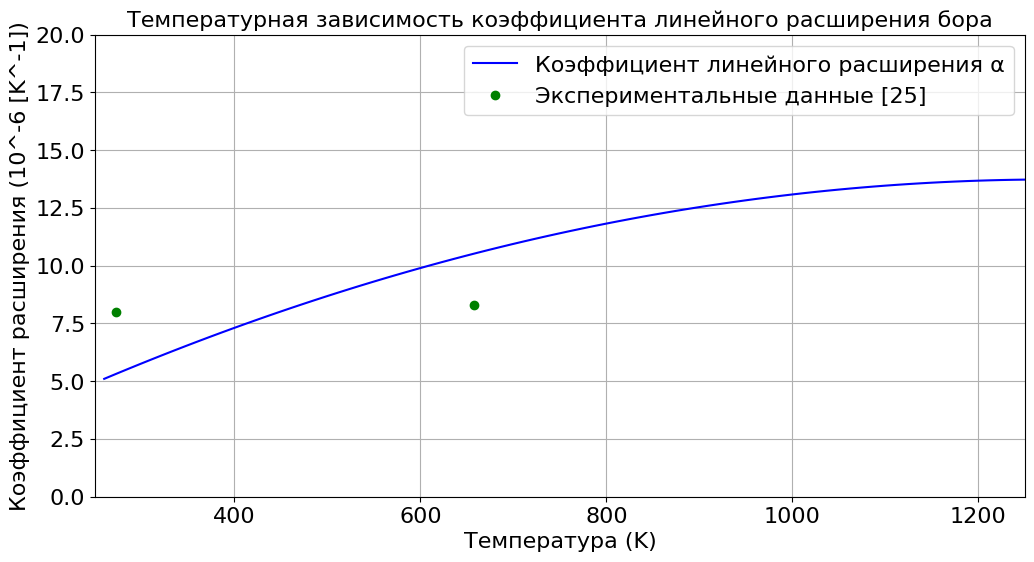

При T = 273K: α_linear = 5.10 × 10⁻⁶ K⁻¹
При T = 658K: α_linear = 10.56 × 10⁻⁶ K⁻¹


In [5]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

c0 = 4.623e-06
c1 = 7.998e-11
c2 = 1.128e-13
c3 = -3.838e-17

yaml_boron = f"""
phases:
- name: boron_poly
  thermo: fixed-stoichiometry
  elements: [B]
  species: [B(s)]
  note: Solid boron with polynomial volume-temperature dependence

species:
- name: B(s)
  composition: {{B: 1}}
  thermo:
    model: constant-cp
    h0: 0
    s0: 5860
    cp0: 11100
  equation-of-state:
    - model: constant-volume
      molar-volume: {c0}  # начальный объем при 300K
    - model: molar-volume-temperature-polynomial
      data:
      - [{c0}, {c1}, {c2}, {c3}]
      - 300  #min(T)
"""


with open("boron_poly.yaml", "w") as f:
    f.write(yaml_boron)

try:
    boron = ct.Solution("boron_poly.yaml")
except ct.CanteraError as e:
    print(f"Ошибка при загрузке решения Кантеры: {e}")
    raise


temperatures = np.linspace(260, 1500, 100) 
alpha_v = np.zeros_like(temperatures)
alpha_l = np.zeros_like(temperatures)
alpha_values = []
for i, T in enumerate(temperatures):
    boron.TP = T, ct.one_atm
    V = boron.volume_mole
    dVdT = (c1 + 2*c2*(T-300) + 3*c3*(T-300)**2)

    alpha_v[i] = (1/V) * dVdT
    alpha_l[i] = alpha_v[i] / 3

plt.figure(figsize=(12, 6))
plt.plot(temperatures, alpha_l*1e6, 'b-', label='Коэффициент линейного расширения α')
#plt.plot(temperatures, alpha_v*1e6, 'r--', label='Коэффициент объемного расширения (α_v × 10^6)')

plt.plot([273, 658], [8, 8.3], 'ko', label='Экспериментальные данные [25]', color="green") 

plt.xlabel('Температура (K)')
plt.ylabel('Коэффициент расширения (10^-6 [K^-1])')
plt.ylim(0, 20)
plt.xlim(250, 1250)
plt.title('Температурная зависимость коэффициента линейного расширения бора')
plt.legend()
plt.grid(True)
plt.show()

print(f"При T = 273K: α_linear = {alpha_l[0]*1e6:.2f} × 10⁻⁶ K⁻¹")
print(f"При T = 658K: α_linear = {alpha_l[np.argmin(np.abs(temperatures-658))]*1e6:.2f} × 10⁻⁶ K⁻¹")